In [1]:
%matplotlib widget
from mmdet3d.datasets import build_dataset
from tools.misc.browse_dataset import build_data_cfg
from mmdet3d.models import apply_3d_transformation
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import copy
import torch
import numpy as np
from mmdet3d.ops.voxel.voxelize import voxelization
from mmdet3d.ops import DynamicScatter
from mmdet3d.ops import (
    flat2window_v2,
    window2flat_v2,
    get_inner_win_inds,
    make_continuous_inds,
    get_flat2win_inds_v2,
    get_window_coors,
)
import time
import pickle
import random

In [2]:
def proj_points_to_2d(points, proj_mat):
    points = torch.cat(
        [
            points[:, :3].reshape(-1, 3),
            torch.ones((points.shape[0], 1), device=points.device),
        ],
        axis=-1,
    )
    points_2d = torch.mm(points, proj_mat.T)
    points_2d[:, 2] = points_2d[:, 2].clip(min=1e-4, max=1e4)
    points_2d[:, 0] /= points_2d[:, 2]
    points_2d[:, 1] /= points_2d[:, 2]
    return points_2d

def points_in_image(points, image_size=(1600, 900)):
    return (
        (0 <= points[:, 0])
        & (points[:, 0] <= image_size[0])
        & (0 <= points[:, 1])
        & (points[:, 1] <= image_size[1])
    )

def window_partition(sparse_shape, window_shape, coors):
        voxel_info = {}
        for i in range(2):
            # Adds indexation which window (counted across all batches) and which spot in the window
            batch_win_inds, coors_in_win = get_window_coors(
                coors, sparse_shape, window_shape, i == 1
            )
            voxel_info[f"batch_win_inds_shift{i}"] = batch_win_inds
            voxel_info[f"coors_in_win_shift{i}"] = coors_in_win

        return voxel_info

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Load input to middle encoder (sst_input_layer_v2)

In [4]:
with open("sst_input_layer.pkl", "rb") as f:
    sst_input_layer = pickle.load(f)

voxel_feats, voxel_coors, voxel_mean, img_metas, batch_size = sst_input_layer

### SST input layer

In [5]:
# Get projection matrix
proj_mats = [
    torch.Tensor(img_meta["lidar2img"][0].reshape(4, 4)).to(voxel_mean.device)
    for img_meta in img_metas
]


# Find batch ranges
batch_start_inds = [
    torch.where(voxel_coors[:, 0] == b)[0][0] for b in range(batch_size)
]
batch_ranges = [
    (batch_start_inds[b], batch_start_inds[b + 1])
    for b in range(batch_size - 1)
]
batch_ranges.append((batch_start_inds[-1], voxel_coors.shape[0]))


# Project voxel mean to 2d
voxel_mean_2d = torch.zeros_like(voxel_mean)
for batch_range, proj_mat in zip(batch_ranges, proj_mats):
    voxel_mean_2d[batch_range[0] : batch_range[1], :] = proj_points_to_2d(
        voxel_mean[batch_range[0] : batch_range[1], :], proj_mat
    )


# Filter out points outside image
is_voxel_mean_in_image = points_in_image(voxel_mean_2d)
voxel_mean_2d_in_image = voxel_mean_2d[is_voxel_mean_in_image, :]
# voxel_coors = voxel_coors[is_voxel_mean_in_image, :]
voxel_feats = voxel_feats[is_voxel_mean_in_image, :]


# Create coordinates in image plane based on projected voxel mean
# voxel_mean_2d_coords = voxel_mean_2d_in_image.flip(1).int()
# voxel_mean_2d_coords[:, 0] = voxel_coors[:, 0]
# voxel_mean_2d_coords[:, 1] = 0
# voxel_mean_2d_coords = voxel_mean_2d_coords.long()

# Window partition
sparse_shape = (200, 200, 1)
window_shape = (16, 16, 1)
#voxel_info = window_partition(sparse_shape, window_shape, voxel_mean_2d_coords)
voxel_info = window_partition(sparse_shape, window_shape, voxel_coors)


/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


### Plot coors painted by window indices

Starting plots
(4, 2)


OSError: [Errno 107] Transport endpoint is not connected: './data/nuscenes/samples/CAM_FRONT/n008-2018-08-29-16-04-13-0400__CAM_FRONT__1535574128262404.jpg'

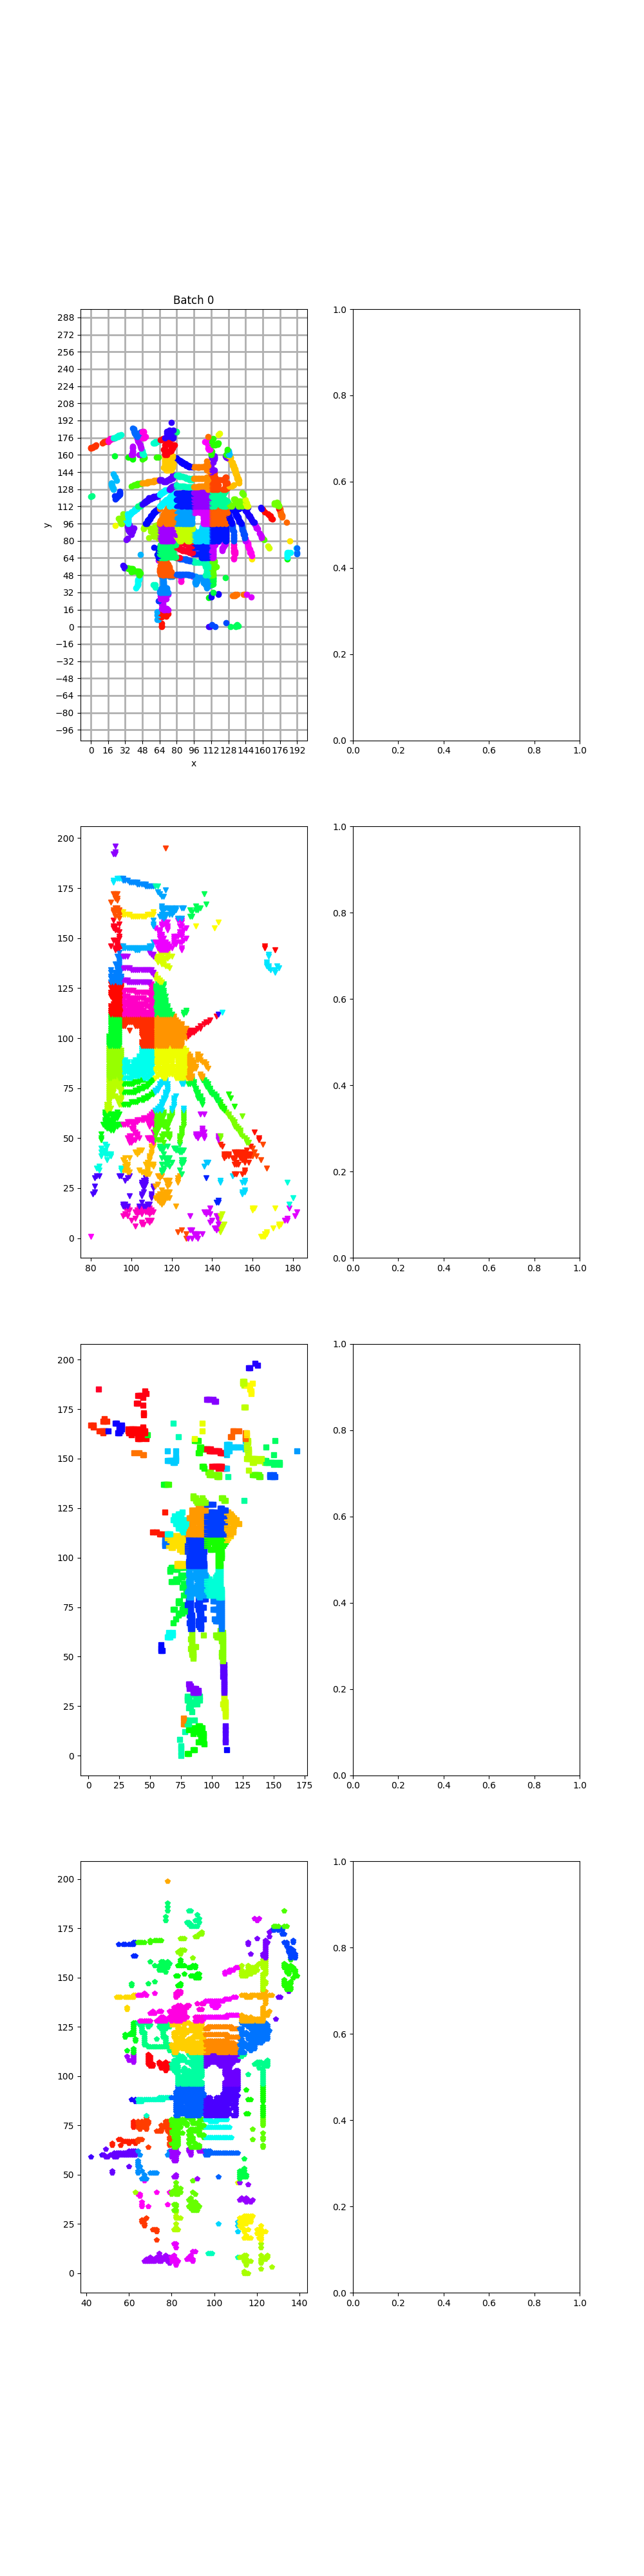

In [6]:
# Create list of colors for each unique value in batch_win_inds_shift0
unique_batch_win_inds = torch.unique(voxel_info["batch_win_inds_shift0"])
color_map = plt.get_cmap("gist_rainbow")
plot_colors = [
    color_map(i / len(unique_batch_win_inds))
    for i in range(len(unique_batch_win_inds))
]
random.shuffle(plot_colors)

# List of plot markers
markers = ["o", "v", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]


# Plot voxel coors painted by batch win ind
fig, axs = plt.subplots(batch_size, 2, figsize=(10, batch_size * 10))
voxel_coors = voxel_coors.cpu().int()

print("Starting plots")
print(axs.shape)
for i in range(voxel_coors.shape[0]):
    batch_index = voxel_coors[i, 0]
    batch_win_ind = voxel_info["batch_win_inds_shift0"][i]
    color_index = torch.where(unique_batch_win_inds == batch_win_ind)[0]
    axs[batch_index, 0].plot(
        voxel_coors[i, 3],
        voxel_coors[i, 2],
        marker=markers[batch_index],
        color=plot_colors[color_index],
    )

for i in range(batch_size):
    axs[i, 0].set_title(f"Batch {i}")
    axs[i, 0].set_xlabel("x")
    axs[i, 0].set_ylabel("y")
    axs[i, 0].xaxis.set_major_locator(MultipleLocator(window_shape[0]))
    axs[i, 0].xaxis.set_major_formatter(FormatStrFormatter("%d"))
    axs[i, 0].yaxis.set_major_locator(MultipleLocator(window_shape[1]))
    axs[i, 0].xaxis.grid(True, "major", linewidth=2)
    axs[i, 0].yaxis.grid(True, "major", linewidth=2)
    axs[i, 0].axis("equal")

    front_img = plt.imread(img_metas[i]["filename"][0])
    axs[i, 1].imshow(front_img)
    axs[i, 1].set_title(f"Batch {i}")